# You are what you eat - Relating Demographic Data to Food Consumption Habits

In [1]:
#%matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # needed for heatmap
from os.path import join
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import pickle
plt.rcParams['figure.figsize'] = [7, 5]

In [2]:
# define paths for data
FOLDER_PATH = 'data'
PURCHASES_PATH = 'area_level_purchases'
OSWARD_GROCERY = 'year_osward_grocery.csv'
WARD_ATLAS = 'ward-atlas-data.csv'

ward_data_path = join(FOLDER_PATH, PURCHASES_PATH, OSWARD_GROCERY)
atlas_data_path = join(FOLDER_PATH, WARD_ATLAS)

# load the data sets
df_ward = pd.read_csv(ward_data_path, sep=',', index_col=0)
df_atlas = pd.read_csv(atlas_data_path, sep=',', encoding='iso-8859-1')

The `df_atlas` data set looks very messy. Row 0 contains info about the data. For every ward and demographic marker yearly (from 2001 to 2006) values exist in columns. According to the [source](https://data.london.gov.uk/dataset/ward-profiles-and-atlas) this data set was collected in September 2015 with the most up-to-date information available. Thus, for many markers, the last available information dates to 2015 or even earlier (e.g. 2013). Our first step is to clean the data set from outdated columns and only keep the most up-to-date demographic markers.

As indicated by the title, we are interested in demographic markers which help classifying different classes of people. These are for example gender, religion, ethnicity, wealth, age. Thus, in the following, we drop columns which we deem not helpful in classifying people into groups. We acknowledge that this process can be rather biased, however, as the data set has 946 columns, we see the need to reduce the data set's complexity.

In [3]:
def drop_redundant_data(df_atlas):
    # clean age (columns after 2013 are projections, therefore keep 2013 columns)
    cond = df_atlas.columns.str.startswith('Population and Age') & ~df_atlas.columns.str.contains('2013')
    df_atlas = df_atlas.loc[:, ~cond]
    # drop absolute population values
    df_atlas = df_atlas.drop(['Population and Age; Population Estimates and Projections; 2013',
                   'Population and Age; Aged 0-15; 2013',
                   'Population and Age; Aged 16-64; 2013',
                   'Population and Age; Aged 65+; 2013',
                   'Population and Age; All ages; 2013',
                   'Population and Age; Mean age; 2013',
                   'Population and Age; Median age; 2013'], axis=1)
    # delete population density
    cond = df_atlas.columns.str.startswith('Area and Density')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete the 18 ethnic groups for now, as they add complexity
    cond = df_atlas.columns.str.startswith('Diversity; Ethnic Group 18 groups')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household language (of no interest) 
    cond = df_atlas.columns.str.startswith('Diversity; Household Language - 2011 Census')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household composition data
    cond = df_atlas.columns.str.startswith('Household composition')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete household repossesion
    cond = df_atlas.columns.str.startswith('Home repossessions')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated birth and death markers
    cond = df_atlas.columns.str.startswith('Births and deaths')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated life expectancy
    cond = df_atlas.columns.str.startswith('Life Expectancy')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated housing markers
    cond = df_atlas.columns.str.startswith('Housing type and Tenure')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('House Prices')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete tax related data (not of interest)
    cond = df_atlas.columns.str.startswith('Dwellings and Council tax')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete dwelling data which is not of interest
    cond = df_atlas.columns.str.startswith('Property Type') | df_atlas.columns.str.startswith('Size of dwellings') | df_atlas.columns.str.startswith('Property build period')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete outdated income data
    cond = df_atlas.columns.str.startswith('Household Income') & ~df_atlas.columns.str.contains('2012/13')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated employment data
    cond = df_atlas.columns.str.startswith('Employment')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete benefits claimants and jobseekers allowance
    cond = df_atlas.columns.str.startswith('Benefits claimants') | df_atlas.columns.str.startswith('Jobseekers Allowance')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete out of work families
    cond = df_atlas.columns.str.startswith('Out-of-Work Families')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated poverty
    cond = df_atlas.columns.str.startswith('Children in Poverty')
    df_atlas = df_atlas.loc[:, ~cond]
    # outdated "intelligence" scores
    cond = df_atlas.columns.str.startswith('GCSE')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('A-Level Point Scores')
    df_atlas = df_atlas.loc[:, ~cond]
    # pupil abscence not if interest
    cond = df_atlas.columns.str.startswith('Pupil Absence')
    df_atlas = df_atlas.loc[:, ~cond]
    # individual crimes not of interest, only crime rate
    cond = df_atlas.columns.str.startswith('Crime') # & ~df_atlas.columns.str.contains('Total crime rate; 2014/15')
    df_atlas = df_atlas.loc[:, ~cond]
    # further columns not of interest
    cond = df_atlas.columns.str.startswith('Fires') | df_atlas.columns.str.startswith('Ambulance') \
    | df_atlas.columns.str.startswith('Binge Drinking') | df_atlas.columns.str.startswith('Road Casualties') \
    | df_atlas.columns.str.startswith('Air Emissions') | df_atlas.columns.str.startswith('Land Use') \
    | df_atlas.columns.str.startswith('Access to green space and nature') | df_atlas.columns.str.startswith('Public Transport Accessibility')\
    | df_atlas.columns.str.startswith('Car access') | df_atlas.columns.str.startswith('Travel to work by bicycle') \
    | df_atlas.columns.str.startswith('Workplace employment') | df_atlas.columns.str.startswith('Nat Insurance No. registrations') \
    | df_atlas.columns.str.startswith('Election turnout')
    df_atlas = df_atlas.loc[:, ~cond]
    # obesity already available in cleaned format
    cond = df_atlas.columns.str.startswith('Childhood Obesity Prevalence')
    df_atlas = df_atlas.loc[:, ~cond]
    # delete old indices of deprivation
    cond = df_atlas.columns.str.startswith('Indices of Deprivation') & ~df_atlas.columns.str.contains('2010')
    df_atlas = df_atlas.loc[:, ~cond]
    cond = df_atlas.columns.str.startswith('Indices of Deprivation') & ~df_atlas.columns.str.endswith('Average Score; 2010')
    df_atlas = df_atlas.loc[:, ~cond]
    
    df_atlas.drop('Unnamed: 0', axis=1, inplace=True)
    df_atlas.drop(df_atlas.index[-3:], inplace=True)
    df_atlas.drop(df_atlas.index[0], inplace=True)
    return df_atlas

df_atlas = drop_redundant_data(df_atlas)

In [4]:
# The first 4 columns seem to have a wrong name
df_atlas.rename(columns={'Unnamed: 1': 'New Code', 'Unnamed: 2': 'Borough', 
                         'Unnamed: 3': 'Names'}, inplace=True)

# very long column names, rename columns to more concise names
import re
rename_map = {name: re.sub('.*; ', '', name) for name in df_atlas.columns.values}
# after inspection 'Household Income; Median Modelled Household income (£); 2012/13',
# 'Household Income; Mean Modelled Household income (£); 2012/13',
# 'Happiness and Well-being; Subjective well-being average score, 2011/12 and 2012/13; ',
# and 'Indices of Deprivation; Average Score; 2010' have been replaced too much, manually add those column names
rename_map['Household Income; Median Modelled Household income (£); 2012/13'] = 'Household Income Mean'
rename_map['Household Income; Mean Modelled Household income (£); 2012/13'] = 'Household Income Median'
rename_map['Happiness and Well-being; Subjective well-being average score, 2011/12 and 2012/13; '] = 'Well-Being'
rename_map['Indices of Deprivation; Average Score; 2010'] = 'IOD AVG'
df_atlas.rename(columns=rename_map, inplace=True)
                         
df_atlas.rename(columns={'% No qualifications': 'No qualifications', 
                         '% Highest level of qualification: Level 1 qualifications': 'Level 1 qualifications', 
                         '% Highest level of qualification: Level 2 qualifications': 'Level 2 qualifications', 
                         '% Highest level of qualification: Apprenticeship': 'Apprenticeship qualifications', 
                         '% Highest level of qualification: Level 3 qualifications': 'Level 3 qualifications', 
                         '% Highest level of qualification: Level 4 qualifications and above': 'Level >=4 qualifications',
                         '% Highest level of qualification: Other qualifications': 'Other qualifications', 
                         '% People with Bad or Very Bad Health': 'Bad Health',
                         '% People whose Day-to-day activities are limited a lot': 'Limited activities'},
                inplace=True)

In [5]:
# to numeric conversion
df_atlas.loc[:, 'Aged 0-15':] = df_atlas.loc[:, 'Aged 0-15':].apply(pd.to_numeric, errors='coerce')

In [6]:
age_cols = ['Aged 0-15', 'Aged 16-64', 'Aged 65+'] #sum to 1
ethnicities_cols = ['White', 'Mixed', 'Asian or Asian British', 'Black or Black British', 'Other'] #sum to 1
religion_cols = ['Christian', 'Buddhist', 'Hindu', 'Jewish', 'Muslim', 'Sikh',
       'No religion', 'Other religions', 'Religion not stated'] # sum to 1
born_cols = ['Born in UK', 'Not Born in UK'] # sum to 1
wealth_cols = ['Household Income Median', 'IOD AVG', 'Well-Being']
qualilication_cols = ['No qualifications', 'Level 1 qualifications', 'Level 2 qualifications',
       'Apprenticeship qualifications', 'Level 3 qualifications',
       'Level >=4 qualifications', 'Other qualifications'] # sum to 1 
disability_cols = ['Bad Health', 'Limited activities']
all_features = age_cols + ethnicities_cols + religion_cols + born_cols + wealth_cols + qualilication_cols + disability_cols

normalizing data

In [7]:
def normalize(df, cols):
    total = df[cols].sum(axis=1)
    df[cols] = df[cols].div(total, axis=0)
    return df

def standartize(df, cols):
    means = df[cols].mean()
    stds = df[cols].std()
    df[cols] = (df[cols] - means) / stds
    return df

def min_max_scaling(df, cols):
    mins = df[cols].min()
    maxs = df[cols].max()
    df[cols] = (df[cols] - mins) / (maxs - mins)
    return df

In [8]:
#normalize
df_atlas[age_cols] /= 100
df_atlas = normalize(df_atlas, ethnicities_cols)
df_atlas = normalize(df_atlas, religion_cols)
df_atlas = normalize(df_atlas, born_cols)
df_atlas[qualilication_cols] /= 100

In [9]:
for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
    print(any(np.abs(df_atlas[cols].sum(axis=1) - 1) > 0.01))

False
False
False
False
False


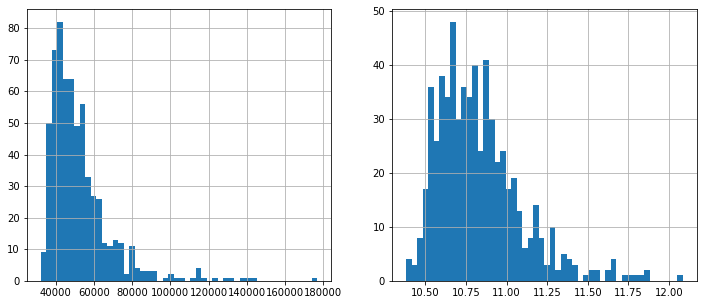

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['Household Income Median'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['Household Income Median'])).hist(bins=50, ax=ax[1])
plt.show()
#haivy-tailed, makes sense to apply log transform before min-max rescaling

In [11]:
df_atlas['Household Income Median'] = df_atlas['Household Income Median'].apply(np.log)

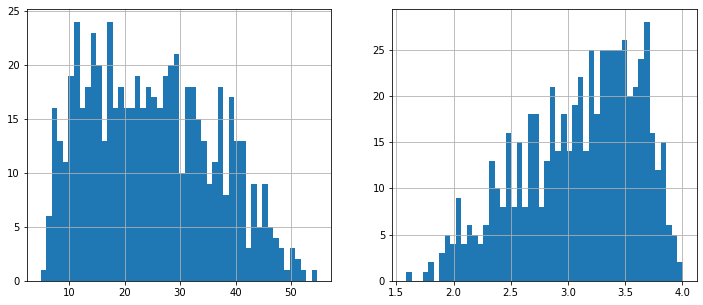

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['IOD AVG'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['IOD AVG'])).hist(bins=50, ax=ax[1])
plt.show()
#no sense to apply log transform

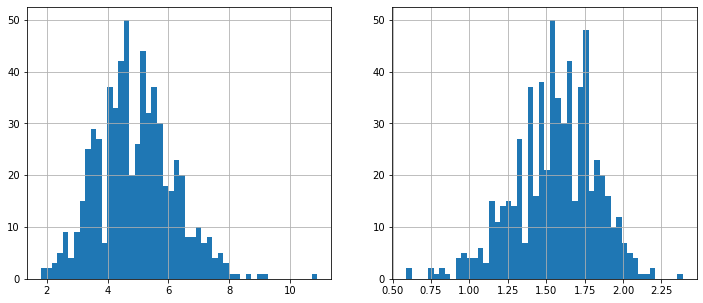

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['Bad Health'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['Bad Health'])).hist(bins=50, ax=ax[1])
plt.show()
#no sense to apply log transform

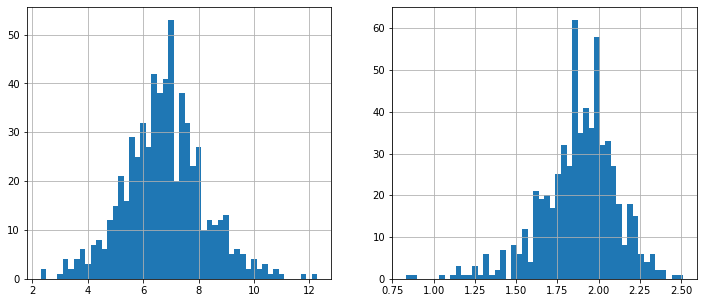

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_atlas['Limited activities'].hist(bins=50, ax=ax[0])
(np.log(df_atlas['Limited activities'])).hist(bins=50, ax=ax[1])
plt.show()
#no sense to apply log transform

In [15]:
#standartizing all features to have 0 mean and 1 variance
for col in all_features:
    df_atlas = standartize(df_atlas, col)

In [16]:
df_atlas[all_features].mean(axis=0)

Aged 0-15                        8.369483e-15
Aged 16-64                      -3.434053e-15
Aged 65+                        -2.079936e-15
White                            1.676259e-15
Mixed                           -2.708034e-15
Asian or Asian British          -1.104894e-16
Black or Black British           2.391509e-15
Other                           -3.463896e-16
Christian                        2.402878e-15
Buddhist                         2.509282e-15
Hindu                           -5.075051e-16
Jewish                          -1.461942e-16
Muslim                           6.918022e-16
Sikh                             5.169198e-17
No religion                      1.002753e-15
Other religions                  2.978950e-16
Religion not stated             -6.980194e-16
Born in UK                      -1.985612e-15
Not Born in UK                  -1.204725e-15
Household Income Median          3.838139e-14
IOD AVG                          1.971756e-17
Well-Being                      -4

In [17]:
df_atlas[all_features].std(axis=0)

Aged 0-15                        1.0
Aged 16-64                       1.0
Aged 65+                         1.0
White                            1.0
Mixed                            1.0
Asian or Asian British           1.0
Black or Black British           1.0
Other                            1.0
Christian                        1.0
Buddhist                         1.0
Hindu                            1.0
Jewish                           1.0
Muslim                           1.0
Sikh                             1.0
No religion                      1.0
Other religions                  1.0
Religion not stated              1.0
Born in UK                       1.0
Not Born in UK                   1.0
Household Income Median          1.0
IOD AVG                          1.0
Well-Being                       1.0
No qualifications                1.0
Level 1 qualifications           1.0
Level 2 qualifications           1.0
Apprenticeship qualifications    1.0
Level 3 qualifications           1.0
L

In [18]:
df_ward.columns.values

array(['weight', 'weight_perc2.5', 'weight_perc25', 'weight_perc50',
       'weight_perc75', 'weight_perc97.5', 'weight_std', 'weight_ci95',
       'volume', 'volume_perc2.5', 'volume_perc25', 'volume_perc50',
       'volume_perc75', 'volume_perc97.5', 'volume_std', 'volume_ci95',
       'fat', 'fat_perc2.5', 'fat_perc25', 'fat_perc50', 'fat_perc75',
       'fat_perc97.5', 'fat_std', 'fat_ci95', 'saturate',
       'saturate_perc2.5', 'saturate_perc25', 'saturate_perc50',
       'saturate_perc75', 'saturate_perc97.5', 'saturate_std',
       'saturate_ci95', 'salt', 'salt_perc2.5', 'salt_perc25',
       'salt_perc50', 'salt_perc75', 'salt_perc97.5', 'salt_std',
       'salt_ci95', 'sugar', 'sugar_perc2.5', 'sugar_perc25',
       'sugar_perc50', 'sugar_perc75', 'sugar_perc97.5', 'sugar_std',
       'sugar_ci95', 'protein', 'protein_perc2.5', 'protein_perc25',
       'protein_perc50', 'protein_perc75', 'protein_perc97.5',
       'protein_std', 'protein_ci95', 'carb', 'carb_perc2.5',
      

In [19]:
important_cols = ['weight', 'volume', 'fat', 'saturate', 'salt', 'sugar', 'protein', 'carb',
                 'fibre', 'alcohol', 'energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot', 'f_energy_fat', 'f_energy_saturate', 
                 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol', 
                 'energy_density', 'h_nutrients_weight', 'h_nutrients_weight_norm', 'h_nutrients_calories',
                  'h_nutrients_calories_norm', 'representativeness_norm']

In [20]:
# before merging set index of df_atlas to the ward code
df_atlas.set_index('New Code', drop=True, inplace=True)

In [21]:
# merge the data sets by ward
df_ward_atlas = pd.merge(df_ward[important_cols], df_atlas, how='inner', left_index=True, right_index=True, validate='1:1')
df_ward_atlas

,weight,volume,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,Level 2 qualifications,Apprenticeship qualifications,Level 3 qualifications,Level >=4 qualifications,Other qualifications,% of 16+ who are schoolchildren and full-time students: Age 18 and over,Bad Health,Limited activities,Well-Being,IOD AVG
E05000026,449.535137,125.960833,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,-0.135178,-0.607835,-0.990268,-0.245565,1.873423,14.3,-0.492858,-1.121216,0.831413,0.694138
E05000027,413.130263,110.664114,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,1.172269,0.118347,-0.589674,-1.629791,-0.257354,5.8,1.409580,1.429760,-0.863156,0.992115
E05000028,407.100472,121.990710,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,0.225425,...,1.047751,0.325827,-0.689822,-1.326505,0.043140,7.7,1.647385,1.429760,-0.076466,0.601395
E05000029,384.173858,122.245578,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,0.200380,...,0.923232,0.533308,-0.239154,-1.412047,-0.421260,5.3,1.488848,2.119213,-1.651271,1.168602
E05000030,356.882607,109.959688,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,0.168952,...,1.421307,1.155749,-0.239154,-1.489813,-1.022248,5.0,0.775434,1.291869,0.799847,0.065051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E05000645,387.651694,100.374890,9.011954,3.558849,0.584727,9.403091,5.499603,16.729870,1.609476,0.292334,...,-1.349235,-0.815315,-1.240639,1.356405,0.015822,6.4,0.616897,0.257690,0.063086,-0.504062
E05000646,391.296517,102.209867,8.810350,3.379945,0.604999,9.350598,5.584789,17.240961,1.640990,0.209072,...,-1.193587,-0.815315,-0.840045,1.200874,0.152411,7.7,0.537629,0.188745,-0.173037,-0.262902
E05000647,391.146713,115.080184,8.642757,3.398100,0.584833,9.446028,5.321004,17.579308,1.680360,0.299310,...,-1.504884,-0.711575,-0.990268,1.620807,-0.038813,7.7,0.220556,-0.500708,1.736755,-0.452034
E05000648,400.832576,109.727023,8.919674,3.512147,0.549463,9.623928,5.259262,17.940815,1.611090,0.195706,...,-0.726642,-0.919055,-0.789971,-0.152246,0.889987,7.4,2.994945,2.739721,1.152150,1.459673


In [22]:
def forward_feature_selection(df_corrs, target_col, verbose=False):

    num_features = 1
    repeat = 100
    best_score = 0
    best_num_features = 0
    delay = 10
    not_improvements = 0

    while (not_improvements < delay) and (num_features < len(df_corrs)):
        features = list(df_corrs[:num_features].keys())
        x_data = df_ward_atlas[features]
        y_data = df_ward_atlas[target_col]
        res_train = []
        res_test = []
        for i in range(repeat):
            x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 1/3)
            model = LinearRegression()
            model.fit(x_train, y_train)
            res_train.append(model.score(x_train, y_train))
            res_test.append(model.score(x_test, y_test))
        res_train = np.array(res_train)
        res_test = np.array(res_test)
        res_train = np.mean(res_train)
        res_test = np.mean(res_test)
        if (res_test > best_score):
            summary_str = 'R2 score on test data improved by {:.5}'.format(res_test-best_score)
            best_score = res_test
            best_num_features = num_features
            not_improvements = 0
        else:
            summary_str = 'R2 score on test data did not improved'
            not_improvements += 1
        if verbose:
            print('Added feature {}: {}'.format(num_features, df_corrs.keys()[num_features-1]))
            print('Average r2_score on train data: {:.5}, on test data {:.5}'.format(res_train, res_test))
            print(summary_str + '\n')
        num_features += 1
    
    return best_score, best_num_features

In [23]:
def forward_feature_selection_brute_force(df_corrs_, target_col, verbose=False):
    num_features = 1
    repeat = 100
    global_test_best = 0
    selected_cols_best = None
    delay = 3
    not_improvements = 0

    df_corrs = df_corrs_.copy()
    selected_cols = []

    while (not_improvements < delay) and (len(df_corrs) > 0):
        res_train = {}
        res_test = {}
        local_train_best = 0
        local_test_best = 0
        best_new_col = None
        for new_col in df_corrs.index:
            trial_cols = selected_cols + [new_col]       
            x_data = df_ward_atlas[trial_cols]
            y_data = df_ward_atlas[target_col]
            res_train[new_col] = []
            res_test[new_col] = []
            for i in range(repeat):
                x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
                model = LinearRegression()
                model.fit(x_train, y_train)
                res_train[new_col].append(model.score(x_train, y_train))
                res_test[new_col].append(model.score(x_test, y_test))
            res_train[new_col] = np.array(res_train[new_col])
            res_test[new_col] = np.array(res_test[new_col])
            res_train[new_col] = np.mean(res_train[new_col])
            res_test[new_col] = np.mean(res_test[new_col])
            if (res_test[new_col] > local_test_best):
                local_test_best = res_test[new_col]
                local_train_best = res_train[new_col]
                best_new_col = new_col
        
        selected_cols.append(best_new_col)
        df_corrs.drop(best_new_col, axis=0, inplace=True)
        if (local_test_best > global_test_best):
            summary_str = 'R2 score on test data improved by {:.5}'.format(local_test_best-global_test_best)
            global_test_best = local_test_best
            selected_cols_best = selected_cols.copy()
            not_improvements = 0
        else:
            summary_str = 'R2 score on test data did not improved'
            not_improvements += 1
        if verbose:
            print('Added feature {}: {}'.format(num_features, best_new_col))
            print('Average r2_score on train data: {:.5}, on test data {:.5}'.format(local_train_best, local_test_best))
            print(summary_str + '\n')
        num_features += 1
        
    return global_test_best, selected_cols_best

In [24]:
target_cols = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']
global_test_best = {}
selected_cols_best = {}
energy_corr = {}
for y in target_cols:
    energy_corr[y] = df_ward_atlas[all_features].corrwith(df_ward_atlas[y], method='pearson')
    energy_corr[y] = energy_corr[y].sort_values(ascending=False, key=np.abs)
    #get rid of linearly dependent cols
    for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
        energy_corr[y].drop(energy_corr[y][cols].index[-1], axis=0, inplace=True)
    global_test_best[y], selected_cols_best[y]  = forward_feature_selection_brute_force(energy_corr[y], y)
    print('{}: best r2 score = {:.5f}, num features = {}'.format(y, global_test_best[y], len(selected_cols_best[y])))

energy_fat: best r2 score = 0.35935, num features = 12
energy_saturate: best r2 score = 0.35390, num features = 12
energy_sugar: best r2 score = 0.59780, num features = 10
energy_protein: best r2 score = 0.61448, num features = 6
energy_carb: best r2 score = 0.76818, num features = 10
energy_fibre: best r2 score = 0.59297, num features = 20
energy_alcohol: best r2 score = 0.40005, num features = 9
energy_tot: best r2 score = 0.66541, num features = 11


In [27]:
f = open("r2_scores_en.pkl","wb")
pickle.dump(global_test_best,f)
f.close()
f = open("selected_cols_en.pkl","wb")
pickle.dump(selected_cols_best,f)
f.close()

In [32]:
f = open("r2_scores_en.pkl","rb")
global_test_best = pickle.load(f)
f.close()
f = open("selected_cols_en.pkl","rb")
selected_cols_best = pickle.load(f)
f.close()
target_cols = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein',
                 'energy_carb', 'energy_fibre', 'energy_alcohol', 'energy_tot']

In [29]:
for y in target_cols:
    print(f'features for \'{y}\' prediction:', selected_cols_best[y])

features for 'energy_fat' prediction: ['Level 1 qualifications', 'Jewish', 'Black or Black British', 'Muslim', 'Aged 0-15', 'Mixed', 'Sikh', 'No religion', 'Level >=4 qualifications', 'Household Income Median', 'Bad Health', 'Apprenticeship qualifications']
features for 'energy_saturate' prediction: ['Asian or Asian British', 'Buddhist', 'Jewish', 'Black or Black British', 'No qualifications', 'Muslim', 'Aged 16-64', 'Mixed', 'IOD AVG', 'Limited activities', 'White', 'Hindu']
features for 'energy_sugar' prediction: ['Level 1 qualifications', 'Mixed', 'No qualifications', 'Jewish', 'Level >=4 qualifications', 'Black or Black British', 'Apprenticeship qualifications', 'Level 3 qualifications', 'IOD AVG', 'Household Income Median']
features for 'energy_protein' prediction: ['Asian or Asian British', 'Jewish', 'Level 1 qualifications', 'Apprenticeship qualifications', 'Sikh', 'No religion']
features for 'energy_carb' prediction: ['Level 1 qualifications', 'Mixed', 'Jewish', 'Household Inco

In [43]:
def to_formula(cols):
    cols = list(map(lambda s: 'Q("{}")'.format(s), cols))
    return ' + '.join(cols)

def get_label_summary(label, features):
    model = smf.ols(formula='{} ~ {}'.format(label, to_formula(features)),
              data=df_ward_atlas)
    res = model.fit()
    results_as_html = res.summary().tables[1].as_html()
    df_summary=pd.read_html(results_as_html, header=0, index_col=0)[0]
    return df_summary[df_summary['P>|t|']<0.05]

def actual_name(col_in_formula):
    if col_in_formula.startswith('Q('):
        return col_in_formula[3:-2]
    else:
        return col_in_formula

In [82]:
def Get_CI_for_r2(target, features):
    repeats = 1000
    r2_scores = []
    
    x_data = df_ward_atlas[features]
    y_data = df_ward_atlas[target]
    for i in range(repeats):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
        model = LinearRegression()
        model.fit(x_train, y_train)
        r2_scores.append(model.score(x_test, y_test))
    return np.array(r2_scores)

In [78]:
r2_scores = {}

# Linear model for energy_fat

In [44]:
target = 'energy_fat'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,81.3222,0.127,641.411,0.000,81.073,81.571
"Q(""Jewish"")",-1.0791,0.148,-7.278,0.000,-1.370,-0.788
"Q(""Black or Black British"")",-1.5320,0.292,-5.239,0.000,-2.107,-0.957
"Q(""Muslim"")",0.9649,0.270,3.575,0.000,0.435,1.495
"Q(""Aged 0-15"")",0.6259,0.201,3.112,0.002,0.231,1.021
"Q(""No religion"")",0.7528,0.245,3.071,0.002,0.271,1.235
"Q(""Apprenticeship qualifications"")",-0.7751,0.362,-2.138,0.033,-1.487,-0.063


Median value for r2-score for energy_fat prediction is 0.31
95%-CI for r2-score for energy_fat prediction: [0.14, 0.47]


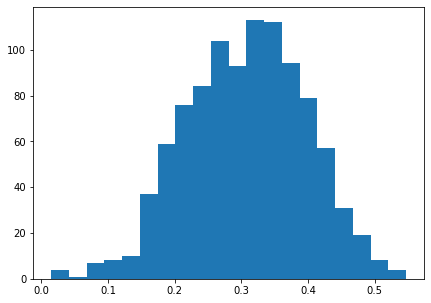

In [81]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [33]:
target = 'energy_fat'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             energy_fat   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     23.61
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           3.56e-41
Time:                        16:22:45   Log-Likelihood:                -1158.2
No. Observations:                 483   AIC:                             2342.
Df Residuals:                     470   BIC:                             2397.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Statistically significant features (with p-value < 0.05): Black or Black British, Asian or Asian British (etnicities), Jewish, Muslim, No religion (religions), Level 1 qualifications, Aged 0-15. More precisely, we see that amount of consumed energy from fats depends on:
1) Etnicity: less for Black or Black British, more for Asian or Asian British. <br>
2) Religion: less for Jewish, more for Muslim and people with no religion. <br>
3) Qualification: more for people with the lowest qualification. <br>
4) Age: more for children (age 0-15)

# Linear model for energy_saturate

In [83]:
target = 'energy_saturate'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,31.9789,0.058,554.183,0.000,31.865,32.092
"Q(""Asian or Asian British"")",1.5668,0.515,3.045,0.002,0.556,2.578
"Q(""Jewish"")",-0.3999,0.064,-6.259,0.000,-0.525,-0.274
"Q(""Muslim"")",0.5972,0.185,3.233,0.001,0.234,0.960
"Q(""Aged 16-64"")",-0.4209,0.106,-3.962,0.000,-0.630,-0.212
"Q(""Mixed"")",0.5269,0.143,3.694,0.000,0.247,0.807
"Q(""Limited activities"")",-0.2522,0.111,-2.265,0.024,-0.471,-0.033
"Q(""White"")",1.4755,0.694,2.125,0.034,0.111,2.840


Median value for r2-score for energy_saturate prediction is 0.34
95%-CI for r2-score for energy_saturate prediction: [0.14, 0.53]


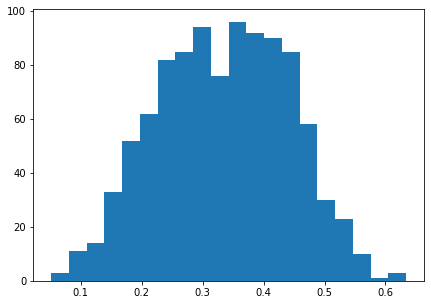

In [84]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [27]:
target = 'energy_saturate'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        energy_saturate   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     23.43
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           6.77e-41
Time:                        12:33:51   Log-Likelihood:                -786.88
No. Observations:                 483   AIC:                             1600.
Df Residuals:                     470   BIC:                             1654.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Linear model for energy_sugar

In [85]:
target = 'energy_sugar'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,40.9918,0.116,354.190,0.000,40.764,41.219
"Q(""Level 1 qualifications"")",3.1267,0.525,5.953,0.000,2.095,4.159
"Q(""Mixed"")",-0.5273,0.220,-2.399,0.017,-0.959,-0.095
"Q(""Jewish"")",-0.4754,0.127,-3.741,0.000,-0.725,-0.226
"Q(""Black or Black British"")",-1.0090,0.267,-3.780,0.000,-1.534,-0.484
"Q(""Apprenticeship qualifications"")",-1.0649,0.301,-3.533,0.000,-1.657,-0.473
"Q(""IOD AVG"")",-0.6398,0.284,-2.256,0.025,-1.197,-0.082


Median value for r2-score for energy_sugar prediction is 0.6
95%-CI for r2-score for energy_sugar prediction: [0.41, 0.71]


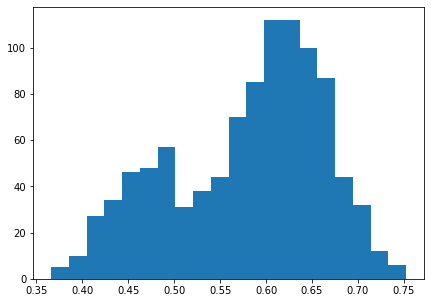

In [86]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [28]:
target = 'energy_sugar'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           energy_sugar   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     67.91
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           7.05e-85
Time:                        12:33:53   Log-Likelihood:                -1119.4
No. Observations:                 483   AIC:                             2261.
Df Residuals:                     472   BIC:                             2307.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Linear model for energy_protein

In [87]:
target = 'energy_protein'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,21.0562,0.026,822.462,0.000,21.006,21.107
"Q(""Asian or Asian British"")",-0.8089,0.054,-15.116,0.000,-0.914,-0.704
"Q(""Jewish"")",-0.3272,0.028,-11.592,0.000,-0.383,-0.272
"Q(""Level 1 qualifications"")",-0.3458,0.049,-7.062,0.000,-0.442,-0.250
"Q(""Apprenticeship qualifications"")",0.0982,0.046,2.133,0.033,0.008,0.189
"Q(""Sikh"")",0.1702,0.030,5.693,0.000,0.111,0.229
"Q(""No religion"")",-0.1699,0.050,-3.417,0.001,-0.268,-0.072


Median value for r2-score for energy_protein prediction is 0.6
95%-CI for r2-score for energy_protein prediction: [0.44, 0.71]


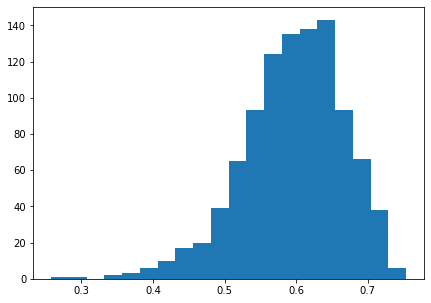

In [88]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [29]:
target = 'energy_protein'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         energy_protein   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     125.8
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           7.04e-95
Time:                        12:33:56   Log-Likelihood:                -401.02
No. Observations:                 483   AIC:                             816.0
Df Residuals:                     476   BIC:                             845.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Linear model for energy_carb

In [89]:
target = 'energy_carb'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,72.9969,0.124,589.629,0.000,72.754,73.240
"Q(""Level 1 qualifications"")",1.4909,0.458,3.256,0.001,0.591,2.391
"Q(""Mixed"")",-1.1297,0.190,-5.948,0.000,-1.503,-0.757
"Q(""Jewish"")",-1.1625,0.149,-7.821,0.000,-1.455,-0.870
"Q(""Household Income Median"")",-1.2475,0.309,-4.043,0.000,-1.854,-0.641
"Q(""Level 2 qualifications"")",2.2470,0.462,4.868,0.000,1.340,3.154
"Q(""Christian"")",-0.9194,0.252,-3.642,0.000,-1.415,-0.423


Median value for r2-score for energy_carb prediction is 0.76
95%-CI for r2-score for energy_carb prediction: [0.68, 0.83]


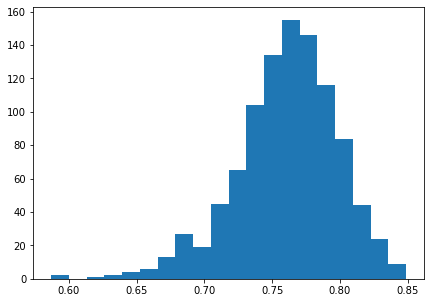

In [90]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [30]:
target = 'energy_carb'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            energy_carb   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     163.7
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          1.88e-146
Time:                        12:33:58   Log-Likelihood:                -1150.8
No. Observations:                 483   AIC:                             2324.
Df Residuals:                     472   BIC:                             2370.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Statistically significant features (with p-value < 0.05): White, Mixed (etnicities), Jewish (religion), Born in UK, Limited activities, Level >=4 qualifications (i. e. maximum level of qualification). More precisely, we see that amount of energy consumed from carbohidrates depends on:
1) Etnicity: less for white and (especially) mixed people than in average
2) Religion: less for Jewish people
3) Place of birth: more for people born in UK than for those who were born abroad
4) Health state: less for people whose Day-to-day activities are limited a lot
5) Qualification: less for highly qualified people, more for low qualified. Here results for 'No qualifications' may be skewed, because this category probably includes all children independently of their mental abilities.

# Linear model for energy_fibre

In [91]:
target = 'energy_fibre'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.0433,0.004,716.468,0.000,3.035,3.052
"Q(""IOD AVG"")",-0.0548,0.015,-3.754,0.000,-0.083,-0.026
"Q(""Black or Black British"")",-0.0305,0.012,-2.543,0.011,-0.054,-0.007
"Q(""Christian"")",-0.0633,0.024,-2.690,0.007,-0.110,-0.017
"Q(""Asian or Asian British"")",-0.0991,0.023,-4.368,0.000,-0.144,-0.055
"Q(""Sikh"")",0.0196,0.009,2.091,0.037,0.001,0.038
"Q(""No qualifications"")",-0.0946,0.026,-3.699,0.000,-0.145,-0.044
"Q(""Level >=4 qualifications"")",-0.1066,0.047,-2.280,0.023,-0.199,-0.015
"Q(""Household Income Median"")",-0.0482,0.014,-3.447,0.001,-0.076,-0.021
"Q(""Mixed"")",-0.0233,0.010,-2.447,0.015,-0.042,-0.005


Median value for r2-score for energy_fibre prediction is 0.59
95%-CI for r2-score for energy_fibre prediction: [0.44, 0.7]


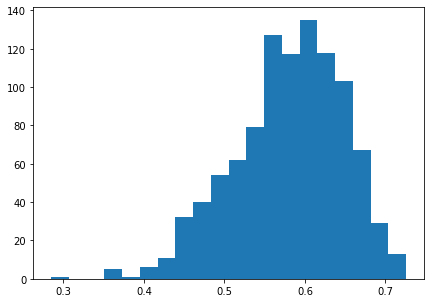

In [92]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [31]:
target = 'energy_fibre'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           energy_fibre   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     38.22
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           1.03e-84
Time:                        12:34:01   Log-Likelihood:                 496.67
No. Observations:                 483   AIC:                            -951.3
Df Residuals:                     462   BIC:                            -863.6
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Linear model for energy_alcohol

In [93]:
target = 'energy_alcohol'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6544,0.013,128.459,0.000,1.629,1.680
"Q(""Level >=4 qualifications"")",0.0858,0.042,2.055,0.040,0.004,0.168
"Q(""Muslim"")",-0.1817,0.029,-6.363,0.000,-0.238,-0.126
"Q(""Jewish"")",-0.0558,0.014,-3.920,0.000,-0.084,-0.028
"Q(""Other religions"")",-0.0393,0.014,-2.888,0.004,-0.066,-0.013
"Q(""Level 2 qualifications"")",-0.1026,0.034,-2.973,0.003,-0.170,-0.035
"Q(""Mixed"")",0.0371,0.017,2.141,0.033,0.003,0.071


Median value for r2-score for energy_alcohol prediction is 0.4
95%-CI for r2-score for energy_alcohol prediction: [0.24, 0.52]


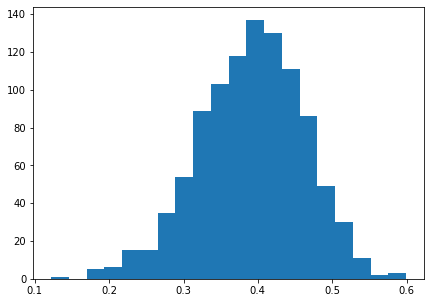

In [94]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [32]:
target = 'energy_alcohol'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         energy_alcohol   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     37.70
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           2.46e-50
Time:                        12:34:03   Log-Likelihood:                -61.042
No. Observations:                 483   AIC:                             142.1
Df Residuals:                     473   BIC:                             183.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

# Linear model for energy_tot

In [96]:
target = 'energy_tot'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,180.3195,0.208,868.743,0.000,179.912,180.727
"Q(""Level 1 qualifications"")",4.0075,0.500,8.015,0.000,3.025,4.990
"Q(""Jewish"")",-2.0511,0.245,-8.381,0.000,-2.532,-1.570
"Q(""Mixed"")",-1.9840,0.363,-5.464,0.000,-2.697,-1.271
"Q(""Aged 0-15"")",0.8483,0.308,2.753,0.006,0.243,1.454
"Q(""No religion"")",1.6985,0.565,3.005,0.003,0.588,2.809
"Q(""IOD AVG"")",-1.3194,0.424,-3.110,0.002,-2.153,-0.486
"Q(""Muslim"")",2.2708,0.510,4.455,0.000,1.269,3.272
"Q(""Born in UK"")",1.4027,0.666,2.106,0.036,0.094,2.712


Median value for r2-score for energy_tot prediction is 0.66
95%-CI for r2-score for energy_tot prediction: [0.5, 0.76]


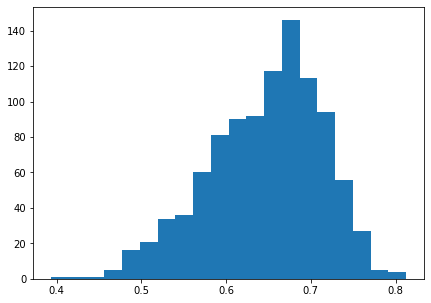

In [97]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [33]:
target = 'energy_tot'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             energy_tot   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     85.51
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          8.43e-105
Time:                        12:34:05   Log-Likelihood:                -1401.4
No. Observations:                 483   AIC:                             2827.
Df Residuals:                     471   BIC:                             2877.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Predicting a fraction of each nutrient energy

In [ ]:
target_cols = ['f_energy_fat', 'f_energy_saturate', 
                 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol']
global_test_best = {}
selected_cols_best = {}
energy_corr = {}
for y in target_cols:
    energy_corr[y] = df_ward_atlas[all_features].corrwith(df_ward_atlas[y], method='pearson')
    energy_corr[y] = energy_corr[y].sort_values(ascending=False, key=np.abs)
    #get rid of linearly dependent cols
    for cols in [age_cols, ethnicities_cols, religion_cols, born_cols, qualilication_cols]:
        energy_corr[y].drop(energy_corr[y][cols].index[-1], axis=0, inplace=True)
    global_test_best[y], selected_cols_best[y]  = forward_feature_selection_brute_force(energy_corr[y], y)
    print('{}: best r2 score = {:.5f}, num features = {}'.format(y, global_test_best[y], len(selected_cols_best[y])))

In [42]:
f = open("r2_scores_fen.pkl","wb")
pickle.dump(global_test_best,f)
f.close()
f = open("selected_cols_fen.pkl","wb")
pickle.dump(selected_cols_best,f)
f.close()

In [99]:
f = open("r2_scores_fen.pkl","rb")
global_test_best = pickle.load(f)
f.close()
f = open("selected_cols_fen.pkl","rb")
selected_cols_best = pickle.load(f)
f.close()

# Linear model for f_energy_fat

In [100]:
target = 'f_energy_fat'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4515,0.000,1209.733,0.000,0.451,0.452
"Q(""Level 2 qualifications"")",-0.0083,0.000,-17.888,0.000,-0.009,-0.007
"Q(""Black or Black British"")",-0.0026,0.000,-5.615,0.000,-0.003,-0.002
"Q(""Aged 0-15"")",0.0017,0.001,3.226,0.001,0.001,0.003


Median value for r2-score for f_energy_fat prediction is 0.44
95%-CI for r2-score for f_energy_fat prediction: [0.27, 0.59]


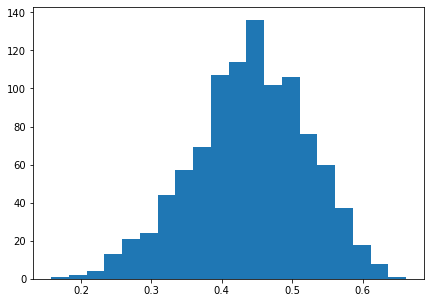

In [101]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [42]:
target = 'f_energy_fat'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           f_energy_fat   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     133.5
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           7.49e-63
Time:                        12:37:35   Log-Likelihood:                 1638.0
No. Observations:                 483   AIC:                            -3268.
Df Residuals:                     479   BIC:                            -3251.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Statistically significant features (with p-value < 0.05) are: Level 2 qualifications, Black or Black British, Born in UK, Aged 0-15, and Hindu. Thus, we see that the fraction of fat in consumed consumed food depends on:

1) Qualification: people with low qualification tend to consume more fat <br>
2) Etnicity: Black or Black British people tend to consume less fat <br>
3) Place of birth: people born in UK tend to consume less fat <br>
4) 

# Linear model for f_energy_saturate

In [102]:
target = 'f_energy_saturate'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1775,0.000,728.678,0.000,0.177,0.178
"Q(""Level 2 qualifications"")",-0.0025,0.001,-2.530,0.012,-0.005,-0.001
"Q(""Black or Black British"")",-0.0039,0.001,-7.265,0.000,-0.005,-0.003
"Q(""Mixed"")",0.0024,0.000,5.002,0.000,0.001,0.003
"Q(""Muslim"")",0.0024,0.001,4.491,0.000,0.001,0.003
"Q(""Level 3 qualifications"")",-0.0007,0.000,-2.736,0.006,-0.001,-0.000
"Q(""Other religions"")",0.0008,0.000,2.995,0.003,0.000,0.001


Median value for r2-score for f_energy_saturate prediction is 0.42
95%-CI for r2-score for f_energy_saturate prediction: [0.25, 0.56]


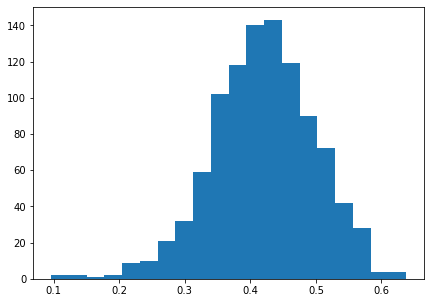

In [103]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [43]:
target = 'f_energy_saturate'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      f_energy_saturate   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     39.72
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           1.58e-56
Time:                        12:37:47   Log-Likelihood:                 1851.2
No. Observations:                 483   AIC:                            -3680.
Df Residuals:                     472   BIC:                            -3634.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Linear model for f_energy_sugar

In [104]:
target = 'f_energy_sugar'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2275,0.000,472.135,0.0,0.227,0.228
"Q(""Asian or Asian British"")",0.0085,0.002,5.285,0.0,0.005,0.012
"Q(""White"")",0.0079,0.002,4.105,0.0,0.004,0.012
"Q(""Level 1 qualifications"")",0.0066,0.002,4.203,0.0,0.004,0.010


Median value for r2-score for f_energy_sugar prediction is 0.42
95%-CI for r2-score for f_energy_sugar prediction: [0.28, 0.53]


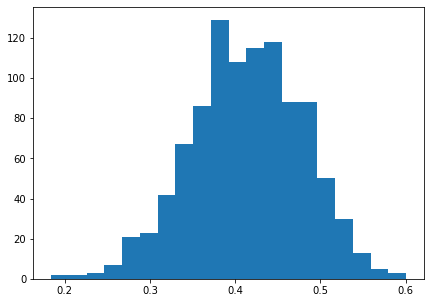

In [105]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [44]:
target = 'f_energy_sugar'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         f_energy_sugar   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     50.97
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           5.33e-54
Time:                        12:37:51   Log-Likelihood:                 1518.7
No. Observations:                 483   AIC:                            -3021.
Df Residuals:                     475   BIC:                            -2988.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Linear model for f_energy_protein

In [106]:
target = 'f_energy_protein'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1171,0.000,640.855,0.000,0.117,0.11700
"Q(""Level >=4 qualifications"")",0.0022,0.001,2.456,0.014,0.000,0.00400
"Q(""Asian or Asian British"")",-0.0057,0.000,-12.036,0.000,-0.007,-0.00500
"Q(""Aged 0-15"")",-0.0009,0.000,-2.140,0.033,-0.002,-0.00007
"Q(""Mixed"")",0.0011,0.000,3.463,0.001,0.000,0.00200
"Q(""Sikh"")",0.0010,0.000,4.946,0.000,0.001,0.00100
"Q(""No religion"")",-0.0029,0.001,-5.124,0.000,-0.004,-0.00200
"Q(""Buddhist"")",0.0008,0.000,3.642,0.000,0.000,0.00100
"Q(""Level 1 qualifications"")",-0.0028,0.001,-2.943,0.003,-0.005,-0.00100


Median value for r2-score for f_energy_protein prediction is 0.7
95%-CI for r2-score for f_energy_protein prediction: [0.58, 0.79]


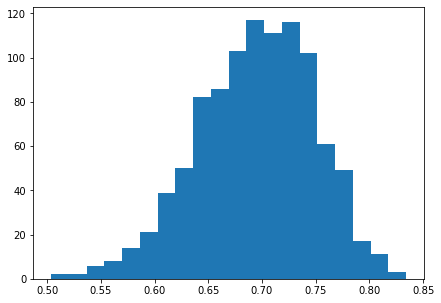

In [107]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [45]:
target = 'f_energy_protein'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       f_energy_protein   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     91.80
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          8.85e-120
Time:                        12:37:54   Log-Likelihood:                 2002.1
No. Observations:                 483   AIC:                            -3976.
Df Residuals:                     469   BIC:                            -3918.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# Linear model for f_energy_carb

In [108]:
target = 'f_energy_carb'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4048,0.000,965.205,0.000,0.404,0.406
"Q(""Level 1 qualifications"")",0.0059,0.001,4.079,0.000,0.003,0.009
"Q(""Hindu"")",0.0032,0.001,4.206,0.000,0.002,0.005
"Q(""Level 2 qualifications"")",0.0074,0.001,4.957,0.000,0.004,0.010
"Q(""Muslim"")",0.0025,0.001,2.368,0.018,0.000,0.005


Median value for r2-score for f_energy_carb prediction is 0.7
95%-CI for r2-score for f_energy_carb prediction: [0.61, 0.77]


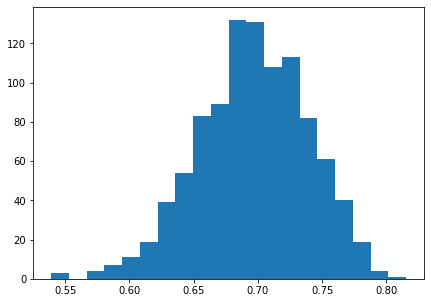

In [109]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [46]:
target = 'f_energy_carb'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          f_energy_carb   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     131.5
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          1.01e-122
Time:                        12:37:59   Log-Likelihood:                 1596.0
No. Observations:                 483   AIC:                            -3172.
Df Residuals:                     473   BIC:                            -3130.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

# Linear model for f_energy_fibre

In [110]:
target = 'f_energy_fibre'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.017000,0.000024,715.225,0.000,0.017000,0.017
"Q(""IOD AVG"")",-0.000400,0.000049,-7.640,0.000,-0.000000,-0.000
"Q(""Jewish"")",0.000200,0.000037,6.124,0.000,0.000000,0.000
"Q(""Asian or Asian British"")",-0.000400,0.000067,-5.863,0.000,-0.001000,-0.000
"Q(""Sikh"")",0.000200,0.000029,6.100,0.000,0.000000,0.000
"Q(""Level 1 qualifications"")",-0.000500,0.000000,-3.844,0.000,-0.001000,-0.000
"Q(""Buddhist"")",0.000081,0.000027,3.010,0.003,0.000028,0.000


Median value for r2-score for f_energy_fibre prediction is 0.76
95%-CI for r2-score for f_energy_fibre prediction: [0.66, 0.83]


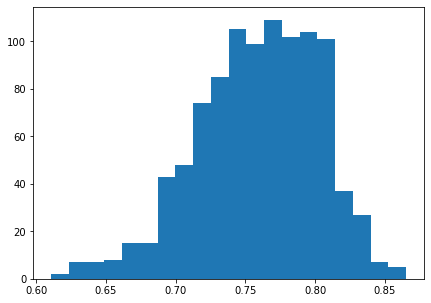

In [111]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [47]:
target = 'f_energy_fibre'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         f_energy_fibre   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     147.2
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          1.11e-144
Time:                        12:38:03   Log-Likelihood:                 2981.0
No. Observations:                 483   AIC:                            -5938.
Df Residuals:                     471   BIC:                            -5888.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

# Linear model for f_energy_alcohol

In [112]:
target = 'f_energy_alcohol'
df_enerfy_fat = get_label_summary(target, selected_cols_best[target])
df_enerfy_fat

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0093,0.000074,124.601,0.000,0.009,0.009000
"Q(""Level >=4 qualifications"")",0.0014,0.000000,12.850,0.000,0.001,0.002000
"Q(""IOD AVG"")",0.0005,0.000000,4.531,0.000,0.000,0.001000
"Q(""Muslim"")",-0.0010,0.000000,-6.117,0.000,-0.001,-0.001000
"Q(""Other religions"")",-0.0002,0.000078,-3.170,0.002,-0.000,-0.000094


Median value for r2-score for f_energy_alcohol prediction is 0.44
95%-CI for r2-score for f_energy_alcohol prediction: [0.28, 0.55]


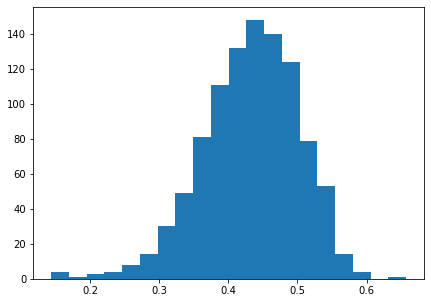

In [113]:
selected_cols_very_best[target] = [actual_name(col) for col in list(df_enerfy_fat.index) if col != 'Intercept']
r2_scores[target] = Get_CI_for_r2(target, selected_cols_very_best[target])
r2_scores[target] = np.sort(r2_scores[target])
n = int(np.round(len(r2_scores[target]) * 0.025))
m = int(np.round(len(r2_scores[target]) * 0.975))
median = np.median(r2_scores[target])
print(f'Median value for r2-score for {target} prediction is {median:.2}')
print(f'95%-CI for r2-score for {target} prediction: [{r2_scores[target][n]:.2}, {r2_scores[target][m]:.2}]')
plt.hist(r2_scores[target], bins=20)
plt.show()

In [48]:
target = 'f_energy_alcohol'
model = smf.ols(formula='{} ~ {}'.format(target, to_formula(selected_cols_best[target])),
              data=df_ward_atlas)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       f_energy_alcohol   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     79.97
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           7.52e-61
Time:                        12:38:06   Log-Likelihood:                 2419.7
No. Observations:                 483   AIC:                            -4827.
Df Residuals:                     477   BIC:                            -4802.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Comparison between energy_nutrient vs f_energy_nutrient r2-scores: <br>
fat: 0.376 vs <b>0.455</b> <br>
saturate: 0.374 vs <b>0.457</b><br>
sugar: <b>0.590</b> vs 0.429<br>
protein: 0.613 vs <b>0.718</b><br>
carb: <b>0.776</b> vs 0.714<br>
fibre: 0.623 vs <b>0.775</b><br>
alcohol: 0.418 vs <b>0.456</b><br>

# Neural Network for predicting all at once

In [24]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import KLDivergence

In [25]:
target_cols = ['f_energy_fat', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre', 'f_energy_alcohol']

In [26]:
df_ward_atlas[target_cols].sum(axis=1)

E05000026    1.0
E05000027    1.0
E05000028    1.0
E05000029    1.0
E05000030    1.0
            ... 
E05000645    1.0
E05000646    1.0
E05000647    1.0
E05000648    1.0
E05000649    1.0
Length: 483, dtype: float64

In [37]:
any(np.abs(df_ward_atlas[target_cols].sum(axis=1) - 1 > 0.01))

False

In [63]:
model = Sequential()
model.add(Input(shape=(30,)))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='sgd', 
              loss=KLDivergence(), 
              metrics=['mean_absolute_error'])

In [60]:
x_data = df_ward_atlas[all_features]
y_data = df_ward_atlas[target_cols]
#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

In [64]:
history = model.fit(x_data, y_data, validation_split=0.2, epochs=300)

Train on 386 samples, validate on 97 samples
Epoch 1/300
386/386 [==============================] - 0s 223us/sample - loss: 0.6217 - mean_absolute_error: 0.1945 - val_loss: 0.4717 - val_mean_absolute_error: 0.1681
Epoch 2/300
386/386 [==============================] - 0s 38us/sample - loss: 0.5361 - mean_absolute_error: 0.1789 - val_loss: 0.4070 - val_mean_absolute_error: 0.1544
Epoch 3/300
386/386 [==============================] - 0s 47us/sample - loss: 0.4643 - mean_absolute_error: 0.1648 - val_loss: 0.3514 - val_mean_absolute_error: 0.1417
Epoch 4/300
386/386 [==============================] - 0s 54us/sample - loss: 0.4010 - mean_absolute_error: 0.1510 - val_loss: 0.3049 - val_mean_absolute_error: 0.1301
Epoch 5/300
386/386 [==============================] - 0s 54us/sample - loss: 0.3477 - mean_absolute_error: 0.1383 - val_loss: 0.2665 - val_mean_absolute_error: 0.1194
Epoch 6/300
386/386 [==============================] - 0s 53us/sample - loss: 0.3057 - mean_absolute_error: 0.1273

386/386 [==============================] - 0s 43us/sample - loss: 0.0089 - mean_absolute_error: 0.0134 - val_loss: 0.0074 - val_mean_absolute_error: 0.0132
Epoch 97/300
386/386 [==============================] - 0s 44us/sample - loss: 0.0087 - mean_absolute_error: 0.0133 - val_loss: 0.0073 - val_mean_absolute_error: 0.0131
Epoch 98/300
386/386 [==============================] - 0s 44us/sample - loss: 0.0086 - mean_absolute_error: 0.0132 - val_loss: 0.0072 - val_mean_absolute_error: 0.0130
Epoch 99/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0084 - mean_absolute_error: 0.0131 - val_loss: 0.0071 - val_mean_absolute_error: 0.0130
Epoch 100/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0083 - mean_absolute_error: 0.0130 - val_loss: 0.0070 - val_mean_absolute_error: 0.0129
Epoch 101/300
386/386 [==============================] - 0s 44us/sample - loss: 0.0082 - mean_absolute_error: 0.0130 - val_loss: 0.0069 - val_mean_absolute_error: 0.01

Epoch 144/300
386/386 [==============================] - 0s 38us/sample - loss: 0.0047 - mean_absolute_error: 0.0106 - val_loss: 0.0042 - val_mean_absolute_error: 0.0107
Epoch 145/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0047 - mean_absolute_error: 0.0106 - val_loss: 0.0042 - val_mean_absolute_error: 0.0106
Epoch 146/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0046 - mean_absolute_error: 0.0106 - val_loss: 0.0041 - val_mean_absolute_error: 0.0106
Epoch 147/300
386/386 [==============================] - 0s 39us/sample - loss: 0.0046 - mean_absolute_error: 0.0105 - val_loss: 0.0041 - val_mean_absolute_error: 0.0106
Epoch 148/300
386/386 [==============================] - 0s 35us/sample - loss: 0.0045 - mean_absolute_error: 0.0105 - val_loss: 0.0041 - val_mean_absolute_error: 0.0105
Epoch 149/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0045 - mean_absolute_error: 0.0104 - val_loss: 0.0040 - val_mean_abs

386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0025 - val_mean_absolute_error: 0.0086
Epoch 241/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0025 - val_mean_absolute_error: 0.0086
Epoch 242/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0.0085
Epoch 243/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0.0085
Epoch 244/300
386/386 [==============================] - 0s 36us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0.0086
Epoch 245/300
386/386 [==============================] - 0s 41us/sample - loss: 0.0025 - mean_absolute_error: 0.0085 - val_loss: 0.0024 - val_mean_absolute_error: 0

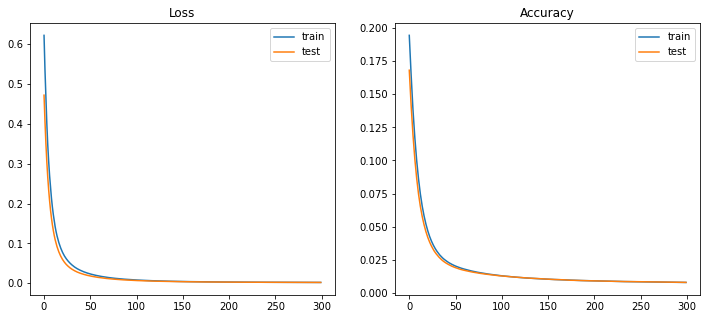

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['mean_absolute_error'], label='train')
ax[1].plot(history.history['val_mean_absolute_error'], label='test')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()